In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom
from lsst.afw import image as afwImage

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

## Imports

In [76]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long  - 5 minutes!!!
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
df_single_gal1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i1)+'.parquet')
df_single_gal2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)
df_single = pd.concat([df_single_ps1, df_single_ps2, df_single_gal1, df_single_gal2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
df_single_gal1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_flux_'+str(i1)+'.parquet')
df_single_gal2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)
df_single_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux, df_single_gal1_flux, df_single_gal2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')

df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe, to get one spatical region
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

# Apply the filter to the dataframe, to get one spatical region
all_obj = df_single[
    (df_single['ra'] >= ra_min) & (df_single['ra'] <= ra_max) &
    (df_single['dec'] >= dec_min) & (df_single['dec'] <= dec_max)]

In [77]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def create_mag(sciFlux):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        if f'lsst_flux_{band}' in df_single_flux_src.columns:
            flux_col = f'lsst_flux_{band}'
            mag_col = f'mag_{band}'
            
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)

def estimate_purity_completness(df_obj, tru_obj, match_value = 1):
    """Estimate the purity and completness of the detected objects
    
        Parameters
    ----------
    obj4_field : `pd.dataframe`
        Detected objects
    tru_obj : `pd.dataframe`
        True variable objects
    match_value : `float`
        matching radius in arcsec    
    
    Returns
    -------
    purity, completeness  : `float`, `float`
        Purity and completness
    """

    # all of the diaObjects in a field
    dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
    # all of the variable objects in a field
    tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
    # match the observations to the truth
    idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
    # index of all diaObj that are within match_value of a true variable object
    idx_close = idx[d2d.to(u.arcsec).value<match_value]

    # all of diaObjects thare are within match_value of a variable object
    matches_close = df_obj.iloc[idx_close]

    # fraction of dia Objects that are actually near a variable objects 
    purity = len(matches_close)/len(df_obj)

    # fraction of variable objects that have been detected 
    completnes = len(matches_close)/len(tru_obj_SC)

    return purity, completnes

def plotFlagImages(exp, flagList=['DETECTED_NEGATIVE', 'DETECTED', 'SENSOR_EDGE', 'INEXACT_PSF']):
    """
    Plot an image with associated mask flags to visualize flagged regions in astronomical imaging data.

    Parameters:
    -----------
    exp : lsst.afw.image.ExposureF
        The exposure object containing the image and associated mask to visualize.
    
    flagList : list of str, optional
        A list of mask plane names to plot. These correspond to specific mask bits in the exposure mask.
        Default is ['DETECTED_NEGATIVE', 'DETECTED', 'SENSOR_EDGE', 'INEXACT_PSF'].

    Returns:
    --------
    None
        Displays a figure with subplots, where the first subplot shows the main image 
        (using ZScale normalization and square root stretch), and the subsequent subplots
        display binary masks for the specified flags.

    Notes:
    ------
    - The first subplot visualizes the `exp.image.array` with a grayscale colormap.
    - Each additional subplot shows a binary image highlighting pixels flagged with the specified mask planes.
    - The function utilizes `ImageNormalize` with `ZScaleInterval` and `SqrtStretch` for the main image visualization.
    - The function suppresses axis tick labels for cleaner visualization.
    """
    
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im


In [78]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'

############################################
pp_collections_1 = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
schema_1 =  f'pp_ppdb_lsstcomcamsim_or4'

pp_collections_2 = 'u/sullii/DM-46333/OR4/association'
schema_2 = 'pp_ppdb_dm46333F2'

pp_collections_3 = 'u/sullii/DM-46333/OR4/databaseTimeoutFix_with_forcedSourceLimit'
schema_3 = f'jeremym_ppdb_replication_test_3'
############################################


pp_collections = pp_collections_3
schema = schema_3

butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

In [79]:
ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value

In [80]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

In [81]:
columns = [
    "diaSourceId", 
    "diaObjectId", 
    "ra", 
    "dec", 
    "raErr", 
    "decErr", 
    "midpointMjdTai", 
    "psfFlux", 
    "psfFluxErr", 
    "scienceFlux", 
    "scienceFluxErr", 
    "snr", 
    "band", 
    "visit",
    "detector",    
    "x",
    "xErr",
    "y",
    "yErr",
    "time_processed", 
    "time_withdrawn",
    "ixx","iyy","ixy",
    "ixxPSF","iyyPSF","ixyPSF",
    "isDipole",
    "centroid_flag",
    "apFlux_flag",
    "apFlux_flag_apertureTruncated",
    "psfFlux_flag",
    "psfFlux_flag_edge",
    "psfFlux_flag_noGoodPixels",
    "trail_flag_edge",
    "forced_PsfFlux_flag",
    "forced_PsfFlux_flag_edge",
    "forced_PsfFlux_flag_noGoodPixels",
    "shape_flag",
    "shape_flag_no_pixels",
    "shape_flag_not_contained",
    "shape_flag_parent_source",
    "pixelFlags",
    "pixelFlags_bad",
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "pixelFlags_edge",
    "pixelFlags_interpolated",
    "pixelFlags_interpolatedCenter",
    "pixelFlags_offimage",
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_injected",
    "pixelFlags_injectedCenter",
    "pixelFlags_injected_template",
    "pixelFlags_injected_templateCenter",
    "reliability"
]

# Convert list of columns into a comma-separated string
columns_string = ', '.join(f'"{col}"' for col in columns)

# Then use this in your SQL query
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            {columns_string}
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [82]:
#latest = False does not work

apdbQuery_3 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_3)
or4_obj_3 = apdbQuery_3.load_objects(limit=1e7, latest=True)

#apdbQuery_2 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_2)
#or4_obj_2 = apdbQuery_2.load_objects(limit=1e7, latest=True)

#apdbQuery_1 = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema_1)
#or4_obj_1 = apdbQuery_1.load_objects(limit=1e7, latest=True)


In [83]:
# lets look at only one field
# objects
#obj4_1_field = or4_obj_1[(or4_obj_1['ra'] > ra_min) & (or4_obj_1['ra'] < ra_max) & (or4_obj_1['dec'] > dec_min) & (or4_obj_1['dec'] < dec_max)]
#obj4_2_field = or4_obj_2[(or4_obj_2['ra'] > ra_min) & (or4_obj_2['ra'] < ra_max) & (or4_obj_2['dec'] > dec_min) & (or4_obj_2['dec'] < dec_max)]
obj4_3_field = or4_obj_3[(or4_obj_3['ra'] > ra_min) & (or4_obj_3['ra'] < ra_max) & (or4_obj_3['dec'] > dec_min) & (or4_obj_3['dec'] < dec_max)]

# src4_1_field = src4_1_field[(or4_src_1['ra'] > ra_min) & (or4_src_1['ra'] < ra_max) & (or4_src_1['dec'] > dec_min) & (or4_src_1['dec'] < dec_max)]
# src4_2_field = src4_1_field[(or4_src_2['ra'] > ra_min) & (or4_src_2['ra'] < ra_max) & (or4_src_2['dec'] > dec_min) & (or4_src_2['dec'] < dec_max)]
src4_3_field = src4_field[(src4_field['ra'] > ra_min) & (src4_field['ra'] < ra_max) & (src4_field['dec'] > dec_min) & (src4_field['dec'] < dec_max)]

In [84]:
# latest rerun
#print(estimate_purity_completness(obj4_1_field, tru_var_obj))
#print(estimate_purity_completness(obj4_2_field, tru_var_obj))
print(estimate_purity_completness(obj4_3_field, tru_var_obj))

#tru_var_obj_bright = tru_var_obj[tru_var_obj['magnorm'] < 22.32]
#print('**********')

#print(estimate_purity_completness(obj4_1_field, tru_var_obj_bright))
#print(estimate_purity_completness(obj4_2_field, tru_var_obj_bright))
# print(estimate_purity_completness(obj4_3_field, tru_var_obj_bright))

(0.06970293486041518, 0.43936830231246476)


In [85]:
# Define the match value in arcseconds (you may want to set this to a specific value)
match_value = 1.0  # for example, 1 arcsecond

# Create SkyCoord objects for src4_3_field_bright and tru_var_obj_bright
src_SC = SkyCoord(ra=obj4_3_field['ra'].values * u.degree, 
                  dec=obj4_3_field['dec'].values * u.degree)

tru_SC = SkyCoord(ra=tru_var_obj['ra'].values * u.degree, 
                  dec=tru_var_obj['dec'].values * u.degree)

# Perform the matching
idx, d2d, d3d = tru_SC.match_to_catalog_sky(src_SC)

# Find the indices of matches within the specified match_value (in arcseconds)
idx_close = idx[d2d.to(u.arcsec).value < match_value]

# Create a boolean array for whether each source in src4_3_field_bright is matched or not
matched = np.zeros(len(obj4_3_field), dtype=int)  # Initialize all as unmatched (0)
matched[idx_close] = 1  # Set the matched objects to 1

obj4_3_field = obj4_3_field.copy()  # Ensure you’re working on a copy, not a view
# Add the 'matched' column to src4_3_field_bright
obj4_3_field.loc[:, 'matched'] = matched

# Now src4_3_field_bright has a 'matched' column with 1 for matches and 0 for no matches

In [86]:
obj4_3_field

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources,matched
145158,3068394109505896606,2024-10-18 21:51:00.698000+00:00,None,215.889012,NaN,-12.896904,NaN,NaN,60487.114560,None,...,None,None,None,None,None,None,None,2024-10-18 21:25:28.781000+00:00,5,0
145189,3068394109505896641,2024-10-18 21:55:48.918000+00:00,None,215.948271,NaN,-12.894971,NaN,NaN,60487.117363,None,...,None,None,None,None,None,None,None,2024-10-18 21:55:05.178000+00:00,20,0
145191,3068394109505896643,2024-10-18 21:30:55.231000+00:00,None,215.906524,NaN,-12.881276,NaN,NaN,60487.100964,None,...,None,None,None,None,None,None,None,2024-10-18 21:23:06.426000+00:00,3,0
145194,3068394109505896646,2024-10-18 21:57:25.471000+00:00,None,215.966894,NaN,-12.899540,NaN,NaN,60487.118303,None,...,None,None,None,None,None,None,None,2024-10-18 21:55:48.918000+00:00,16,0
145195,3068394109505896647,2024-10-18 21:57:26.755000+00:00,None,215.922370,7.087633e-07,-12.885341,7.524305e-07,1.306441e-14,60487.118303,None,...,None,None,None,None,None,None,None,2024-10-18 21:55:48.918000+00:00,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166068,3068394172890218555,2024-10-18 21:59:46.165000+00:00,None,215.690908,3.576009e-05,-12.306796,2.190436e-05,3.927373e-11,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0
166069,3068394172890218582,2024-10-18 21:59:46.165000+00:00,None,215.665284,2.189263e-05,-12.264642,4.058586e-05,-5.387281e-11,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0
166070,3068394172890218584,2024-10-18 21:59:46.165000+00:00,None,215.600868,NaN,-12.264713,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0
166071,3068394172890218587,2024-10-18 21:59:46.165000+00:00,None,215.677023,2.319316e-05,-12.260069,2.911627e-05,-1.373439e-11,60487.119709,None,...,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1,0


In [87]:
src4_3_field['detector'].unique()

array([3, 1, 8, 0, 5, 7, 2, 6, 4])

In [88]:
src4_3_field['visit'].unique()

array([7024062500190, 7024062500191, 7024062500192, 7024062500193,
       7024062500194, 7024062500196, 7024062500197, 7024062500198,
       7024062500199, 7024062500200, 7024062500195, 7024062500201,
       7024062500202, 7024062500203, 7024062500204, 7024062500206,
       7024062500207, 7024062500205, 7024062500208, 7024062500209,
       7024062500210, 7024062500215, 7024062500216, 7024062500220,
       7024062500221, 7024062500222, 7024062500217, 7024062500218,
       7024062500223, 7024062500219, 7024062500224, 7024062500227,
       7024062500228, 7024062500230, 7024062500231, 7024062500232,
       7024062500225, 7024062500226, 7024062500234, 7024062500235,
       7024062500237, 7024062500238, 7024062500239, 7024062500229,
       7024062500240, 7024062500241, 7024062500242, 7024062500233,
       7024062500243, 7024062500244, 7024062500236, 7024062500246,
       7024062500248, 7024062500249, 7024062500245, 7024062500247,
       7024062500211, 7024062500212, 7024062500213, 7024062500

In [89]:
# Merge the two DataFrames based on 'diaObjectId', preserving all rows in src4_3_field_bright
src4_3_field = src4_3_field.merge(obj4_3_field[['diaObjectId', 'matched']], 
                                                on='diaObjectId', 
                                                how='left')

In [90]:
src4_3_field_positive = src4_3_field[(src4_3_field['psfFlux'] > 0) & (src4_3_field['isDipole'] == False)]

# MWV plot

In [91]:
src_subselection = src4_3_field_positive[['diaSourceId','ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'snr', 'shape_flag', 'matched']]
src_subselection_matched = src_subselection[src_subselection['matched'] == 1]
src_subselection_not_matched = src_subselection[src_subselection['matched'] == 0]

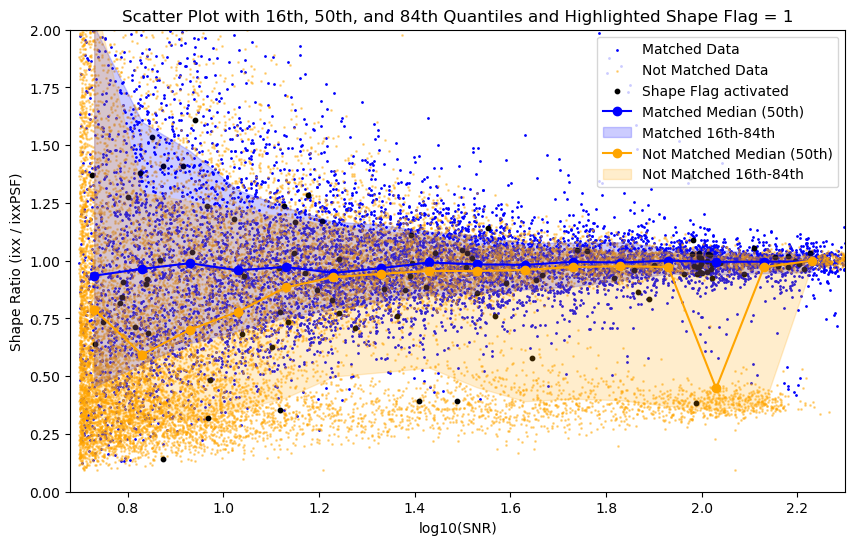

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data, excluding NaNs
log_snr_matched = np.log10(src_subselection_matched['snr'])
shape_ratio_matched = src_subselection_matched['ixx'] / src_subselection_matched['ixxPSF']
mask_matched = ~np.isnan(log_snr_matched) & ~np.isnan(shape_ratio_matched)
log_snr_matched = log_snr_matched[mask_matched]
shape_ratio_matched = shape_ratio_matched[mask_matched]

log_snr_not_matched = np.log10(src_subselection_not_matched['snr'])
shape_ratio_not_matched = src_subselection_not_matched['ixx'] / src_subselection_not_matched['ixxPSF']
mask_not_matched = ~np.isnan(log_snr_not_matched) & ~np.isnan(shape_ratio_not_matched)
log_snr_not_matched = log_snr_not_matched[mask_not_matched]
shape_ratio_not_matched = shape_ratio_not_matched[mask_not_matched]

# Identify points in src_subselection_matched where shape_flag is exactly 1
highlighted_log_snr = log_snr_matched[src_subselection_matched['shape_flag'] == 1]
highlighted_shape_ratio = shape_ratio_matched[src_subselection_matched['shape_flag'] == 1]

# Define bins
bins = np.arange(0.68, 2.3, 0.1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Calculate 16th, 50th, and 84th percentiles in each bin for matched data
q16_matched, q50_matched, q84_matched = [], [], []

for i in range(len(bins) - 1):
    in_bin_matched = (log_snr_matched >= bins[i]) & (log_snr_matched < bins[i + 1])
    bin_shape_ratio_matched = shape_ratio_matched[in_bin_matched]
    if len(bin_shape_ratio_matched) > 0:  # Only calculate if data is available
        q16_matched.append(np.percentile(bin_shape_ratio_matched, 16))
        q50_matched.append(np.percentile(bin_shape_ratio_matched, 50))
        q84_matched.append(np.percentile(bin_shape_ratio_matched, 84))
    else:
        q16_matched.append(np.nan)
        q50_matched.append(np.nan)
        q84_matched.append(np.nan)

# Calculate 16th, 50th, and 84th percentiles in each bin for non-matched data
q16_not_matched, q50_not_matched, q84_not_matched = [], [], []

for i in range(len(bins) - 1):
    in_bin_not_matched = (log_snr_not_matched >= bins[i]) & (log_snr_not_matched < bins[i + 1])
    bin_shape_ratio_not_matched = shape_ratio_not_matched[in_bin_not_matched]
    if len(bin_shape_ratio_not_matched) > 0:  # Only calculate if data is available
        q16_not_matched.append(np.percentile(bin_shape_ratio_not_matched, 16))
        q50_not_matched.append(np.percentile(bin_shape_ratio_not_matched, 50))
        q84_not_matched.append(np.percentile(bin_shape_ratio_not_matched, 84))
    else:
        q16_not_matched.append(np.nan)
        q50_not_matched.append(np.nan)
        q84_not_matched.append(np.nan)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plots for matched and not matched data
plt.scatter(log_snr_matched, shape_ratio_matched, s=1, label='Matched Data', color='blue')
plt.scatter(log_snr_not_matched, shape_ratio_not_matched, s=1, alpha=0.4, label='Not Matched Data', color='orange')

# Highlight points where shape_flag is exactly 1 with black circles
plt.scatter(highlighted_log_snr, highlighted_shape_ratio, edgecolor='black', facecolor='black', s=10, label='Shape Flag activated')

# Plotting quantiles for matched data
plt.plot(bin_centers, q50_matched, 'o-', color='blue', label='Matched Median (50th)')
plt.fill_between(bin_centers, q16_matched, q84_matched, color='blue', alpha=0.2, label='Matched 16th-84th')

# Plotting quantiles for not matched data
plt.plot(bin_centers, q50_not_matched, 'o-', color='orange', label='Not Matched Median (50th)')
plt.fill_between(bin_centers, q16_not_matched, q84_not_matched, color='orange', alpha=0.2, label='Not Matched 16th-84th')

# Axis limits and labels
plt.ylim(0, 2)
plt.xlim(0.68, 2.3)
plt.xlabel('log10(SNR)')
plt.ylabel('Shape Ratio (ixx / ixxPSF)')
plt.title('Scatter Plot with 16th, 50th, and 84th Quantiles and Highlighted Shape Flag = 1')
plt.legend()

plt.show()

In [19]:
shape_ratio_matched

41       0.915158
90       1.046488
94       0.819471
96       1.138070
109      0.841056
           ...   
72121    0.976481
72131    1.047780
72145    1.334111
72147    1.041593
72154    2.006736
Length: 9539, dtype: float64

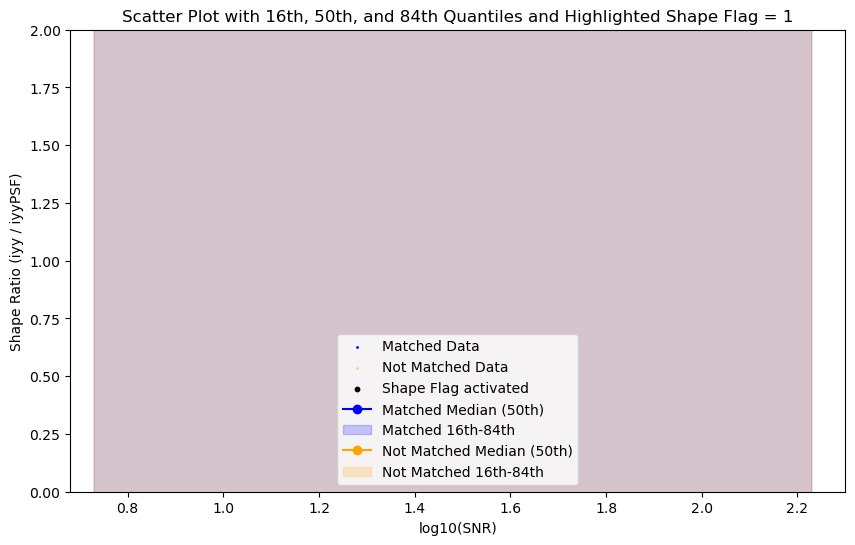

In [20]:
# Prepare the data, excluding NaNs
log_snr_matched = np.log10(src_subselection_matched['snr'])
shape_ratio_matched = src_subselection_matched['iyy'] / src_subselection_matched['iyyPSF']
mask_matched = ~np.isnan(log_snr_matched) & ~np.isnan(shape_ratio_matched)
log_snr_matched = log_snr_matched[mask_matched]
shape_ratio_matched = shape_ratio_matched[mask_matched]

log_snr_not_matched = np.log10(src_subselection_not_matched['snr'])
shape_ratio_not_matched = src_subselection_not_matched['iyy'] / src_subselection_not_matched['iyyPSF']
mask_not_matched = ~np.isnan(log_snr_not_matched) & ~np.isnan(shape_ratio_not_matched)
log_snr_not_matched = log_snr_not_matched[mask_not_matched]
shape_ratio_not_matched = shape_ratio_not_matched[mask_not_matched]

# Identify points in src_subselection_matched where shape_flag is exactly 1
highlighted_log_snr = log_snr_matched[src_subselection_matched['shape_flag'] == 1]
highlighted_shape_ratio = shape_ratio_matched[src_subselection_matched['shape_flag'] == 1]

# Define bins
bins = np.arange(0.68, 2.3, 0.1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Calculate 16th, 50th, and 84th percentiles in each bin for matched data
q16_matched, q50_matched, q84_matched = [], [], []

for i in range(len(bins) - 1):
    in_bin_matched = (log_snr_matched >= bins[i]) & (log_snr_matched < bins[i + 1])
    bin_shape_ratio_matched = shape_ratio_matched[in_bin_matched]
    if len(bin_shape_ratio_matched) > 0:  # Only calculate if data is available
        q16_matched.append(np.percentile(bin_shape_ratio_matched, 16))
        q50_matched.append(np.percentile(bin_shape_ratio_matched, 50))
        q84_matched.append(np.percentile(bin_shape_ratio_matched, 84))
    else:
        q16_matched.append(np.nan)
        q50_matched.append(np.nan)
        q84_matched.append(np.nan)

# Calculate 16th, 50th, and 84th percentiles in each bin for non-matched data
q16_not_matched, q50_not_matched, q84_not_matched = [], [], []

for i in range(len(bins) - 1):
    in_bin_not_matched = (log_snr_not_matched >= bins[i]) & (log_snr_not_matched < bins[i + 1])
    bin_shape_ratio_not_matched = shape_ratio_not_matched[in_bin_not_matched]
    if len(bin_shape_ratio_not_matched) > 0:  # Only calculate if data is available
        q16_not_matched.append(np.percentile(bin_shape_ratio_not_matched, 16))
        q50_not_matched.append(np.percentile(bin_shape_ratio_not_matched, 50))
        q84_not_matched.append(np.percentile(bin_shape_ratio_not_matched, 84))
    else:
        q16_not_matched.append(np.nan)
        q50_not_matched.append(np.nan)
        q84_not_matched.append(np.nan)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plots for matched and not matched data
plt.scatter(log_snr_matched, shape_ratio_matched, s=1, label='Matched Data', color='blue')
plt.scatter(log_snr_not_matched, shape_ratio_not_matched, s=1, alpha=0.4, label='Not Matched Data', color='orange')

# Highlight points where shape_flag is exactly 1 with black circles
plt.scatter(highlighted_log_snr, highlighted_shape_ratio, edgecolor='black', facecolor='black', s=10, label='Shape Flag activated')

# Plotting quantiles for matched data
plt.plot(bin_centers, q50_matched, 'o-', color='blue', label='Matched Median (50th)')
plt.fill_between(bin_centers, q16_matched, q84_matched, color='blue', alpha=0.2, label='Matched 16th-84th')

# Plotting quantiles for not matched data
plt.plot(bin_centers, q50_not_matched, 'o-', color='orange', label='Not Matched Median (50th)')
plt.fill_between(bin_centers, q16_not_matched, q84_not_matched, color='orange', alpha=0.2, label='Not Matched 16th-84th')

# Axis limits and labels
plt.ylim(0, 2)
plt.xlim(0.68, 2.3)
plt.xlabel('log10(SNR)')
plt.ylabel('Shape Ratio (iyy / iyyPSF)')
plt.title('Scatter Plot with 16th, 50th, and 84th Quantiles and Highlighted Shape Flag = 1')
plt.legend()

plt.show()

(0.68, 2.3)

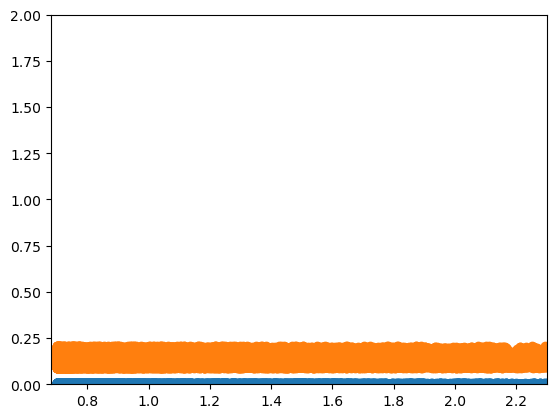

In [21]:

#plt.scatter(np.log10(src_subselection['snr']), src_subselection['iyy'])
#plt.scatter(np.log10(src_subselection['snr']), src_subselection['ixx'])

plt.scatter(np.log10(src_subselection['snr']), src_subselection['iyyPSF'])
plt.scatter(np.log10(src_subselection['snr']), src_subselection['ixxPSF'])
# Axis limits and labels
plt.ylim(0, 2)
plt.xlim(0.68, 2.3)

Text(0.5, 1.0, 'Shape Histogram of diaSources, OR4')

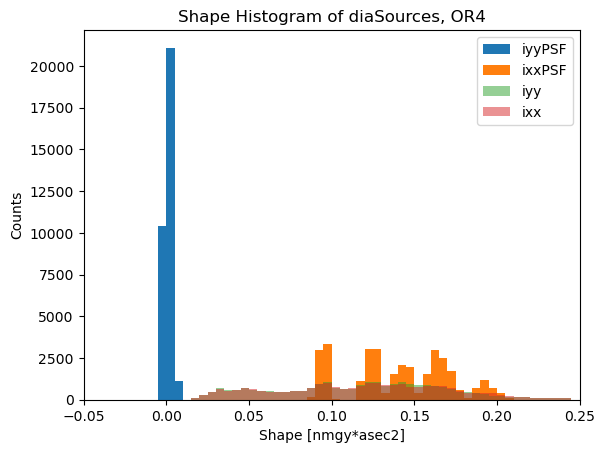

In [22]:
plt.hist(src_subselection['iyyPSF'],  bins=np.arange(-0.25,0.25,0.005), label='iyyPSF');
plt.hist(src_subselection['ixxPSF'],  bins=np.arange(-0.25,0.25,0.005), label='ixxPSF');

plt.hist(src_subselection['iyy'],  bins=np.arange(-0.25,0.25,0.005), label='iyy',alpha=0.5);
plt.hist(src_subselection['ixx'],  bins=np.arange(-0.25,0.25,0.005), label='ixx', alpha=0.5);

plt.xlim(-0.05, 0.25)
plt.legend()
plt.xlabel('Shape [nmgy*asec2]')
plt.ylabel('Counts')
plt.title('Shape Histogram of diaSources, OR4')

Text(0.5, 1.0, 'Shape Histogram of diaSources, OR4')

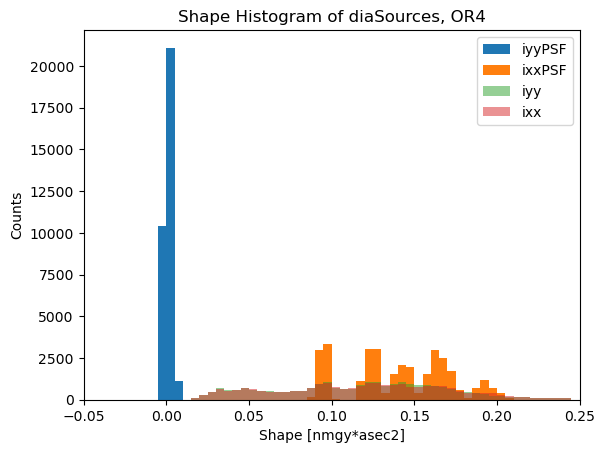

In [23]:
plt.hist(src_subselection['iyyPSF'],  bins=np.arange(-0.25,0.25,0.005), label='iyyPSF');
plt.hist(src_subselection['ixxPSF'],  bins=np.arange(-0.25,0.25,0.005), label='ixxPSF');

plt.hist(src_subselection['iyy'],  bins=np.arange(-0.25,0.25,0.005), label='iyy',alpha=0.5);
plt.hist(src_subselection['ixx'],  bins=np.arange(-0.25,0.25,0.005), label='ixx', alpha=0.5);

plt.xlim(-0.05, 0.25)
plt.legend()
plt.xlabel('Shape [nmgy*asec2]')
plt.ylabel('Counts')
plt.title('Shape Histogram of diaSources, OR4')

In [24]:
data1= {'detector': 5, 'visit': 7024062500237}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
forced_src_via_butler = pp_butler.get('goodSeeingDiff_diaForcedSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)
src_prefilter_via_butler = pp_butler.get('goodSeeingDiff_diaSrc', dataId=data1)

columns = src_cand_via_butler.schema.getNames()  # Get all column names
data = {col: src_cand_via_butler[col].tolist() for col in columns}  # Extract each column's data

# Create a pandas DataFrame
single_butler_cand_src_df = pd.DataFrame(data)

single_butler_cand_src_df[['ext_shapeHSM_HsmSourceMoments_xx','ext_shapeHSM_HsmSourceMoments_yy',
                           'ext_shapeHSM_HsmPsfMoments_xx','ext_shapeHSM_HsmPsfMoments_yy',
                           'id']]

,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,id
0,2.488151,5.545056,3.567533,3.483336,3068394159992733697
1,4.813294,3.642441,3.567533,3.483336,3068394159992733698
2,NaN,NaN,3.567533,3.483336,3068394159992733699
3,3.131409,3.082570,3.567533,3.483336,3068394159992733701
4,NaN,NaN,3.567533,3.483336,3068394159992733702
...,...,...,...,...,...
117,NaN,NaN,3.567533,3.483336,3068394159992733830
118,7.284929,7.920243,3.567533,3.483336,3068394159992733831
119,4.114625,4.031333,3.567533,3.483336,3068394159992733832
120,5.641823,4.424905,3.567533,3.483336,3068394159992733834


In [25]:
krnl = pp_butler.get('goodSeeingDiff_psfMatchKernel', dataId=data1)


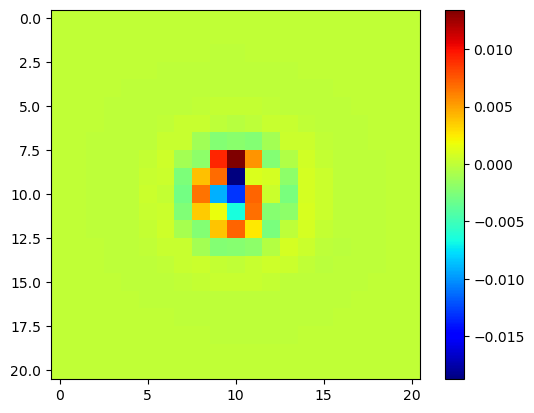

In [26]:
size_x = 4000
size_y = 4000
baseimage = afwImage.ImageD(krnl.getBBox())
krnl.computeImage(baseimage, doNormalize=True, x=size_x/2,y=size_y/2)
center_krnl = baseimage.array.copy()

size_x = 500
size_y = 500
krnl.computeImage(baseimage, doNormalize=True, x=size_x/2,y=size_y/2)
edge_krnl = baseimage.array.copy()

plt.imshow(center_krnl - edge_krnl,cmap='jet')
plt.colorbar()

In [27]:
data1= {'detector': 5, 'visit': 7024062500237}
src_cand_via_butler = pp_butler.get('goodSeeingDiff_diaSrc', dataId=data1)
src_cand_via_butler.getPsfIxx()

array([3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753323,
       3.56753323, 3.56753323, 3.56753323, 3.56753323, 3.56753

In [28]:
data1= {'detector': 5, 'visit': 7024062500237}
src_cand_via_butler = pp_butler.get('goodSeeingDiff_diaSrc', dataId=data1)
src_cand_via_butler.getIxx()

array([ 2.48815098,  4.8132941 ,         nan,  3.13140924,         nan,
        3.57453167,  1.5798311 ,  0.90538211,  4.35879573,  1.01172578,
        2.52488531,  0.97761945,         nan,  3.12490711,  3.73455112,
        1.21330578,  4.83313105,  3.53681432,  3.4772538 ,  0.75242982,
               nan,         nan,         nan,  3.19188126,         nan,
               nan,         nan,  3.12768713,  1.65258481,  1.19691684,
        0.73802423,  0.73717707,  3.57738658,  3.18861197,  4.18440305,
               nan,  3.7455532 ,  3.45763896,  9.80580636,  3.43444685,
        4.06853187,  3.99264903,  7.74673892,  2.86616576,  2.52759099,
        4.09157866,  2.78960005,  3.78756307,  1.23023018,  0.43595303,
        4.7309666 ,  3.60832852,  3.19016563,  1.25566716,  3.42533254,
        3.6895818 ,  1.76309403,  3.20493191,  1.73304506,  1.69114547,
        3.05062169,  4.0668847 ,  3.60303235,         nan,         nan,
        3.17118363,  2.08241027,  3.57707547,  3.53722033,      

In [29]:
data1= {'detector': 6, 'visit': 7024062500237}
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)
src_cand_via_butler.getPsfIxx()

array([3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921

In [30]:
src_via_butler[['ixx','iyy','ixxPSF','iyyPSF','snr','shape_flag','diaSourceId']]

,,,ixx,iyy,ixxPSF,iyyPSF,snr,shape_flag,diaSourceId
diaObjectId,band,diaSourceId,,,,,,,
3068394153550282805,r,3068394159992733697,0.099821,0.222460,0.143124,0.002538,7.255472,False,3068394159992733697
3068394157832667189,r,3068394159992733698,0.193086,0.146117,0.143112,0.002538,5.767836,False,3068394159992733698
3068394109526868111,r,3068394159992733699,NaN,NaN,0.143119,0.002538,7.524729,True,3068394159992733699
3068394109526868126,r,3068394159992733701,0.125596,0.123637,0.143089,0.002537,16.166908,False,3068394159992733701
3068394109522673779,r,3068394159992733703,0.143338,0.141103,0.143058,0.002537,692.596985,False,3068394159992733703
...,...,...,...,...,...,...,...,...,...
3068394159992733744,r,3068394159992733744,0.393396,0.089562,0.143125,0.002538,5.396151,False,3068394159992733744
3068394159992733755,r,3068394159992733755,0.017485,0.587023,0.143084,0.002537,5.101635,True,3068394159992733755
3068394159992733763,r,3068394159992733763,0.070697,0.042560,0.143052,0.002536,5.241005,True,3068394159992733763


In [31]:
src_cand_via_butler.getPsfIxx()

array([3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921472,
       3.50921472, 3.50921472, 3.50921472, 3.50921472, 3.50921

In [32]:
single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394159992733743]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394159992733743]
single_butler_prefilter_src = src_prefilter_via_butler[src_prefilter_via_butler['id'] == 3068394159992733743]

In [33]:
single_butler_src[['ixx', 'iyy']]

,,,ixx,iyy
diaObjectId,band,diaSourceId,,
3068394159992733743,r,3068394159992733743,0.138623,0.145822


# Faint sources

# https://dmtn-006.lsst.io
# https://dmtn-021.lsst.io

In [95]:
visit_id = src4_3_field['visit'].unique()

0.2956996374014125
3983.6184440502852


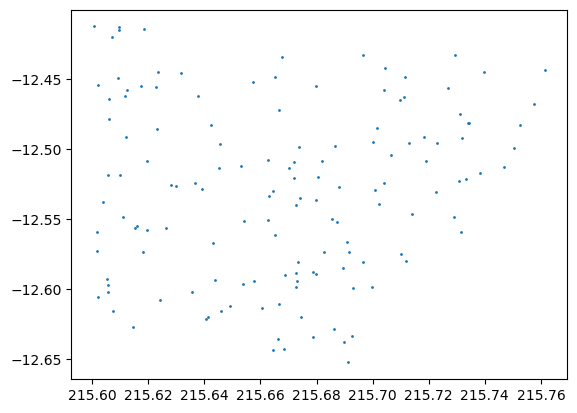

In [96]:
single_visit_srcs_example = src4_3_field[src4_3_field['visit'] == visit_id[0]][['ra','dec', 'x', 'y', 'detector']]
single_visit_srcs_example_square = single_visit_srcs_example[(single_visit_srcs_example['ra']<216.1)\
    & (single_visit_srcs_example['ra']>215.6) & (single_visit_srcs_example['dec']<-12.3)]

# Extract RA and Dec values
ra = single_visit_srcs_example_square['ra'].values
dec = single_visit_srcs_example_square['dec'].values
# Combine RA and Dec into a single array of points
points = np.vstack((ra, dec)).T
# Compute the convex hull
hull = ConvexHull(points)
# Get the vertices of the hull
hull_vertices = points[hull.vertices]
# Calculate the area of the convex hull in square degrees
# ConvexHull.area returns the perimeter, so here we calculate the area manually
hull_area_deg2 = 0.5 * np.abs(np.dot(hull_vertices[:, 0], np.roll(hull_vertices[:, 1], 1)) - np.dot(hull_vertices[:, 1], np.roll(hull_vertices[:, 0], 1)))
print(hull_area_deg2)

# Extract RA and Dec values
ra = single_visit_srcs_example_square['x'].values
dec = single_visit_srcs_example_square['y'].values
# Combine RA and Dec into a single array of points
points = np.vstack((ra, dec)).T
# Compute the convex hull
hull = ConvexHull(points)
# Get the vertices of the hull
hull_vertices = points[hull.vertices]
# Calculate the area of the convex hull in square degrees
# ConvexHull.area returns the perimeter, so here we calculate the area manually
hull_area_xy = 0.5 * np.abs(np.dot(hull_vertices[:, 0], np.roll(hull_vertices[:, 1], 1)) - np.dot(hull_vertices[:, 1], np.roll(hull_vertices[:, 0], 1)))
print(np.sqrt(hull_area_xy))

single_visit_srcs_example_square_dec = single_visit_srcs_example_square[single_visit_srcs_example_square['detector'] == 5]
plt.scatter(single_visit_srcs_example_square_dec['ra'], single_visit_srcs_example_square_dec['dec'], s=1)



In [97]:
single_visit_srcs_example_square_dec

# Extract RA and Dec values
ra = single_visit_srcs_example_square_dec['ra'].values
dec = single_visit_srcs_example_square_dec['dec'].values

# Combine RA and Dec into a single array of points
points = np.vstack((ra, dec)).T

# Compute the convex hull
hull = ConvexHull(points)

# Get the vertices of the hull
hull_vertices = points[hull.vertices]

# Calculate the area of the convex hull in square degrees
# ConvexHull.area returns the perimeter, so here we calculate the area manually
hull_area_deg2 = 0.5 * np.abs(np.dot(hull_vertices[:, 0], np.roll(hull_vertices[:, 1], 1)) - np.dot(hull_vertices[:, 1], np.roll(hull_vertices[:, 0], 1)))

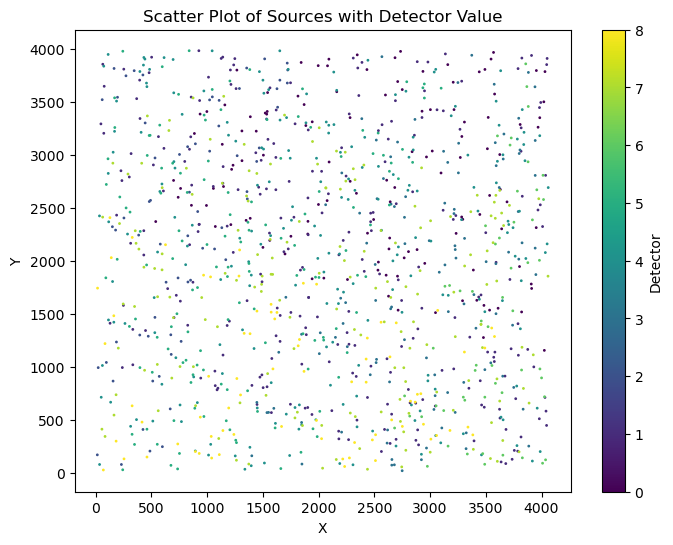

In [98]:
# Scatter plot with color based on 'detector' values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    single_visit_srcs_example_square['x'], 
    single_visit_srcs_example_square['y'], 
    s=1, 
    c=single_visit_srcs_example_square['detector'], 
    cmap='viridis',  # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm')
    alpha=1  # Optional: Adjust transparency for better visualization
)

# Add a colorbar to show the detector values
plt.colorbar(scatter, label='Detector')

# Set labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of Sources with Detector Value")

plt.show()



In [99]:
import numpy as np
from scipy.spatial import ConvexHull

list_of_hull_areas_deg2 = []
for i in range(len(visit_id)):
    
    single_visit_srcs = src4_3_field[src4_3_field['visit'] == visit_id[i]][['ra','dec']]

    # Extract RA and Dec values
    ra = single_visit_srcs['ra'].values
    dec = single_visit_srcs['dec'].values

    # Combine RA and Dec into a single array of points
    points = np.vstack((ra, dec)).T

    # Compute the convex hull
    hull = ConvexHull(points)

    # Get the vertices of the hull
    hull_vertices = points[hull.vertices]

    # Calculate the area of the convex hull in square degrees
    # ConvexHull.area returns the perimeter, so here we calculate the area manually
    hull_area_deg2 = 0.5 * np.abs(np.dot(hull_vertices[:, 0], np.roll(hull_vertices[:, 1], 1)) - np.dot(hull_vertices[:, 1], np.roll(hull_vertices[:, 0], 1)))
    
    list_of_hull_areas_deg2.append(hull_area_deg2)


In [100]:
# total 4000x4000 areas
np.array(list_of_hull_areas_deg2).sum()/0.3

82.67662939822912

In [101]:



def n_l_v(v):
    return (1/(2**(5/2)*np.pi**(3/2)))*v**1*np.exp(-v**2/2)

# sigma is 1.6? https://lsstc.slack.com/archives/C064M4D6RC4/p1712160675864159
def N_tot(v, sigma):
    return n_l_v(v)/sigma**2 *4000**2

list_of_predicted_sources = [] 
for i in np.arange(2, 8, 0.2):
    list_of_predicted_sources.append([i, 82.6* N_tot(i, 1.6)])

array_of_predicted_sources = np.array(list_of_predicted_sources)

In [102]:
array_of_predicted_sources_hist = np.transpose([array_of_predicted_sources[:-1][:,0], -np.diff(array_of_predicted_sources[:,1])])

In [104]:
# Suppress scientific notation in NumPy
np.set_printoptions(suppress=True, precision=2)
array_of_predicted_sources


array([[      2.  , 4436099.7 ],
       [      2.2 , 3206197.72],
       [      2.4 , 2208022.02],
       [      2.6 , 1450835.81],
       [      2.8 ,  910508.34],
       [      3.  ,  546205.86],
       [      3.2 ,  313416.96],
       [      3.4 ,  172114.35],
       [      3.6 ,   90497.07],
       [      3.8 ,   45576.16],
       [      4.  ,   21991.98],
       [      4.2 ,   10170.26],
       [      4.4 ,    4508.61],
       [      4.6 ,    1916.38],
       [      4.8 ,     781.14],
       [      5.  ,     305.39],
       [      5.2 ,     114.53],
       [      5.4 ,      41.2 ],
       [      5.6 ,      14.22],
       [      5.8 ,       4.71],
       [      6.  ,       1.5 ],
       [      6.2 ,       0.46],
       [      6.4 ,       0.13],
       [      6.6 ,       0.04],
       [      6.8 ,       0.01],
       [      7.  ,       0.  ],
       [      7.2 ,       0.  ],
       [      7.4 ,       0.  ],
       [      7.6 ,       0.  ],
       [      7.8 ,       0.  ]])

(0.0, 7500.0)

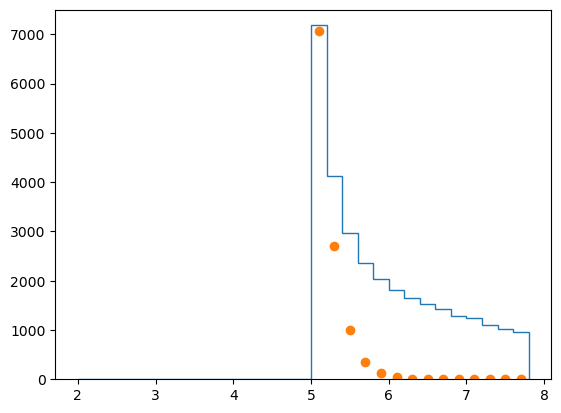

In [105]:
plt.hist(src4_3_field['snr'].values, np.arange(2, 8, 0.2), histtype='step', label='snr');
plt.scatter(array_of_predicted_sources_hist[:,0]+0.1, 37*array_of_predicted_sources_hist[:,1], label='predicted sources')
plt.ylim(0, 7500)

In [ ]:
#TODO - check if there are skysources in this plot 
#  0.195 arcsec is the edge size of the pixel
# check the diaSoruce catalog in diaPipe goodseeingdiff_associationDiaSrc should have sky sources column, if any are true
# analysis tools for skysources, do skysources follow the same distribution exponential distribution as orange 
# variance is rescaled empirically, is there a metric ; all of them should be there
# any processing hsc, is there still this psf difference in hsc
# the plot for different cameras (HSC), with number of diaSrc for magnitude/src

In [43]:
data1= {'detector': 5, 'visit': 7024062500237}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)

In [51]:
list(src_via_butler.columns)

['diaSourceId',
 'visit',
 'detector',
 'diaObjectId',
 'ssObjectId',
 'parentDiaSourceId',
 'ssObjectReassocTime',
 'midpointMjdTai',
 'ra',
 'raErr',
 'dec',
 'decErr',
 'ra_dec_Cov',
 'x',
 'xErr',
 'y',
 'yErr',
 'x_y_Cov',
 'centroid_flag',
 'apFlux',
 'apFluxErr',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'snr',
 'psfFlux',
 'psfFluxErr',
 'psfRa',
 'psfRaErr',
 'psfDec',
 'psfDecErr',
 'psfFlux_psfRa_Cov',
 'psfFlux_psfDec_Cov',
 'psfRa_psfDec_Cov',
 'psfLnL',
 'psfChi2',
 'psfNdata',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trailFlux',
 'trailFluxErr',
 'trailRa',
 'trailRaErr',
 'trailDec',
 'trailDecErr',
 'trailLength',
 'trailLengthErr',
 'trailAngle',
 'trailAngleErr',
 'trailFlux_trailRa_Cov',
 'trailFlux_trailDec_Cov',
 'trailFlux_trailLength_Cov',
 'trailFlux_trailAngle_Cov',
 'trailRa_trailDec_Cov',
 'trailRa_trailLength_Cov',
 'trailRa_trailAngle_Cov',
 'trailDec_trailLength_Cov',
 'trailDec_trailAngle_Cov',
 'trailLength_trailAn

In [55]:
src_prefilter_via_butler['sky_source']

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,

In [70]:
data1= {'detector': 5, 'visit': 7024062500237}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
forced_src_via_butler = pp_butler.get('goodSeeingDiff_diaForcedSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)
src_prefilter_via_butler = pp_butler.get('goodSeeingDiff_diaSrc', dataId=data1)


In [72]:
len(src_prefilter_via_butler['coord_ra'][real_src_filter])

122

In [73]:
len(src_prefilter_via_butler['coord_ra'][~real_src_filter])

100

In [74]:
len(src_via_butler['ra'])

122

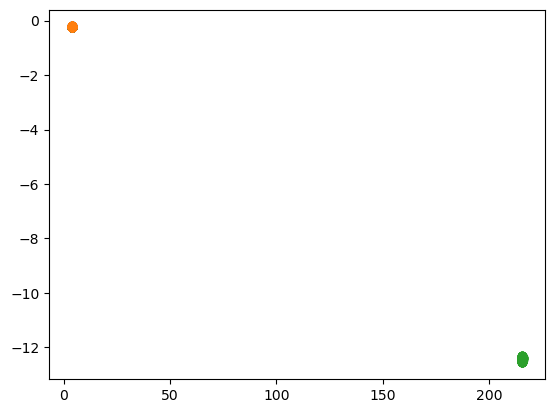

In [71]:
plt.scatter(src_prefilter_via_butler['coord_ra'][real_src_filter],src_prefilter_via_butler['coord_dec'][real_src_filter])
plt.scatter(src_prefilter_via_butler['coord_ra'][~real_src_filter],src_prefilter_via_butler['coord_dec'][~real_src_filter])
plt.scatter(src_via_butler['ra'],src_via_butler['dec'])